In [28]:
import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
data_dir = "C:/Users/hosei/Documents/DataSets/GTSRB"
train_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Train/"
test_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Test/"
meta_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Meta/"

meta_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Meta.csv')
train_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Train.csv')
test_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Test.csv')

In [30]:
#hyper parametes
num_of_classes = len(os.listdir(train_path))
height = 30
width = 30
channels = 3
n_inputs = height * width * num_of_classes
num_epochs = 2
batch_size = 4
learning_rate = 0.001

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# folders = os.listdir(train_path)

# train_number = []
# class_num = []

# for folder in folders:
#     train_files = os.listdir(train_path + '/' + folder)
#     train_number.append(len(train_files))
#     class_num.append(classes[int(folder)])

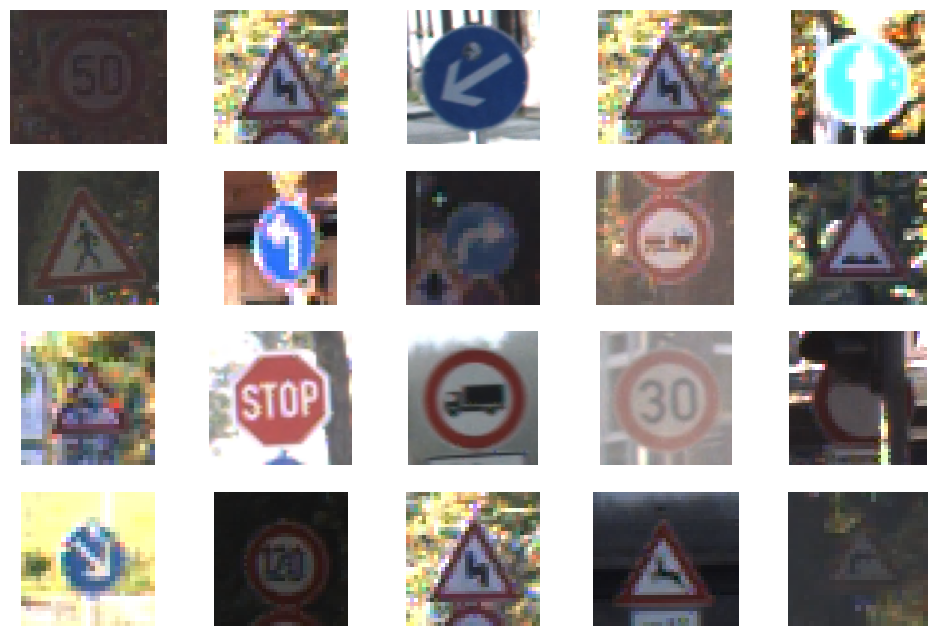

In [33]:

folder_names = [os.path.join(train_path, str(i)) for i in random.choices(range(43), k=20)]
file_names = [os.path.join(fldr, os.listdir(fldr)[0]) for fldr in folder_names]

fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, image_path in enumerate(file_names):
    image = Image.open(image_path)
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.show();

In [34]:
# Transforming the Data ToTensor and Normalize it 

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((27,27)),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
class GTSR_DataSet(Dataset):
    def __init__(self, df, root_dir,transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_path = os.path.join(self.root_dir,self.df.iloc[index,7])  #the column of paths in dataframe is 7
        image = Image.open(image_path)
        y_class = torch.tensor(self.df.iloc[index, 6]) #the column of ClsassId in daraframe is 6
        
        if self.transform:
            image = self.transform(image)
            return (image, y_class)

In [35]:
training_set = GTSR_DataSet(train_df,data_dir,transform=transforms)
test_set = GTSR_DataSet(test_df,data_dir,transform=transforms)

In [41]:
train_loader = DataLoader(dataset = training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=batch_size, shuffle=False)

dataloaders = {'training':train_loader,'testing':test_loader}
dataset_sizes = {'training':len(train_loader.dataset),'testing':len(test_loader.dataset)}
print(dataset_sizes)

{'training': 39209, 'testing': 12630}


In [48]:
class GTRSB_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(GTRSB_Model, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.AdaptiveMaxPool2d(32)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.maxpool2 = nn.AdaptiveMaxPool2d(128)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(1024)
        self.maxpool3 = nn.AdaptiveMaxPool2d(512)

        
        self.l1 = nn.Linear(1024*4*4,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_size)




    def forward(self,input):
        conv = self.conv1(input)
        conv = self.conv2(conv)
        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool1(batchnorm)
        conv = self.conv3(maxpool)
        conv = self.conv4(conv)
        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool2(batchnorm)

        conv = self.conv5(maxpool)
        conv = self.conv6(conv)
        batchnorm = self.relu(self.batchnorm3(conv))
        maxpool = self.maxpool3(batchnorm)
    

              
        flatten = self.flatten(maxpool)
        
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        
    
        return output

        

In [49]:
input_size = 3*27*27
output_size = 43
model = GTRSB_Model(input_size=input_size, output_size=output_size)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
for epoch in range(len(train_loader)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            n_samples +=labels.shape[0]
            n_correct +=(predictions == labels).sum().item()
        acc = 100.0 * (n_correct / n_samples)
        print(f'accuracy = {acc}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x268435456 and 16384x512)